In here we tried to perform the model on lsoa level, summerzing all the sentences vectors within one lsoa, use these to predict gentrification.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer, util
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score

In [2]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled_25_only.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [3]:
stru_data = pd.read_csv("data/all_stru_data_added.csv")
print(stru_data.columns)

Index(['LSOA Code', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per'],
      dtype='object')


In [4]:
stru_data = stru_data.rename(columns={'LSOA Code': 'LSOA code'})
lsoa_label = lsoa_label.merge(stru_data, on= "LSOA code", how="left")

In [5]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [6]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
import ast
from shapely.geometry import Polygon
import geopandas as gpd

# 1. 去掉空值
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()

# 2. 如果是字符串形式的 list，先转为真正的 list
text_valid["geometry"] = text_valid["wgs84_polygon.coordinates"].apply(
    lambda coords: Polygon(ast.literal_eval(coords)[0]) if isinstance(coords, str) else Polygon(coords[0])
)

# 3. 创建 GeoDataFrame，设置坐标系
gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [7]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [8]:
joined = gpd.sjoin(gdf_27700, lsoa_label[["LSOA code", "geometry", "gentrified", "pop_growth_rate", 
                                          "price_grow", "avg_den", "senior_per", "minority_per"]], 
                                          how="left", predicate="within")

In [9]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [10]:
# spatial join
joined = gpd.sjoin(gdf_27700, lsoa_label, how="left", predicate="within")

In [11]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["LSOA code", "geometry", "gentrified", "pop_growth_rate", 
                                                                            "price_grow", "avg_den", "senior_per", "minority_per"]],
                                                                            how="left",predicate="within")

In [12]:
joined_cleaned = joined_centroid[joined_centroid["gentrified"].notna()].copy()
joined_cleaned.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'geometry', 'centroid', 'index_right', 'LSOA code', 'gentrified',
       'pop_growth_rate', 'price_grow', 'avg_den', 'senior_per',
       'minority_per'],
      dtype='object', length=411)

In [13]:
lsoa_counts = joined_cleaned.groupby('LSOA code').size().reset_index(name='application_count')

<Axes: >

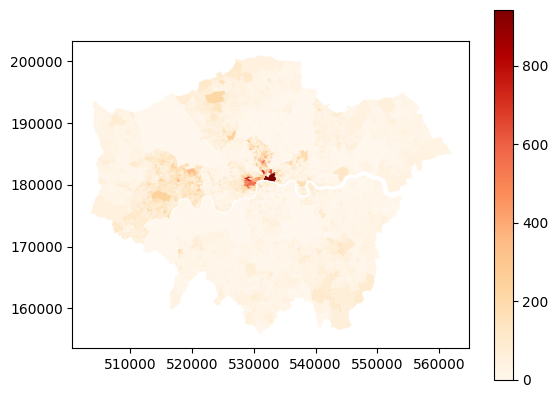

In [14]:
# gdf_lsoa: 是你读取的 LSOA 边界数据
lsoa_label = lsoa_label.merge(lsoa_counts, on='LSOA code', how='left')
lsoa_label['application_count'] = lsoa_label['application_count'].fillna(0).astype(int)

# 地图可视化
lsoa_label.plot(column='application_count', cmap='OrRd', legend=True)

In [15]:
print(lsoa_counts.head(5))

   LSOA code  application_count
0  E01000001                 48
1  E01000002                 87
2  E01000003                 34
3  E01000005                 98
4  E01000006                  1


In [16]:
# 按 LSOA 编码分组，取均值（你也可以试试 sum、max 等方式）
sbert_cols = [f"sbert_{i}" for i in range(384)]
lsoa_vecs = joined_cleaned.groupby("LSOA code")[sbert_cols].mean()

# struct_cols = ['pop_growth_rate', 'avg_den', 'senior_per', 'minority_per']
# lsoa_struct = joined_cleaned.groupby("LSOA code")[struct_cols].mean()

# lsoa_combined = lsoa_vecs.join(lsoa_struct, how='left')

# lsoa_label = joined_cleaned[['LSOA code', 'gentrified']].drop_duplicates()
# lsoa_combined = lsoa_combined.reset_index().merge(lsoa_label, on="LSOA code", how="left")


In [17]:
joined_cleaned.head

<bound method NDFrame.head of                                                 site_name decision_date  \
0                                                            2016-05-26   
1                                        Residential Unit    2015-10-28   
2                                                            2015-05-12   
3                                    McDonalds Restaurant    2015-07-03   
4                                                            2015-10-19   
...                                                   ...           ...   
192565                     140 Bruce Road, London, E3 3EU    2019-06-17   
192568                      11 Rum Close, London, E1W 3QX    2019-06-24   
192578  Site On East Side North Of Railway Bridge Betw...    2020-04-28   
192579  Calders Wharf, Saunders Ness Road, London, E14...    2019-09-24   
192581               82 West India Dock Road, London, E14    2019-10-21   

       valid_date                                 polygon.geometries 

# SBERT

In [18]:
anchor_dict = {
    "residential": ["flat conversion", "refurbishment", "rear extension", 
                    "luxury dwelling", "windows"],
    "commercial": ["coffee shop", "illuminated sign", "retail unit upgrade", 
                   "change use", "digital screen"],
    "green": ["park improvement", "landscaping", "tree planting"],
    "cultural": ["artist studios", "cultural space", "gallery conversion"],
    "infrustructure": ["station upgrade", "utilities improvement", "lighting enhancement", 
                       "cycle", "parking"]
}
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# 正确计算平均向量：
anchor_vecs = {
    k: np.mean(sbert_model.encode(v), axis=0) for k, v in anchor_dict.items()
}

In [19]:
# from sklearn.metrics.pairwise import cosine_similarity

# # 示例：一列句子向量 (shape: N x 384)，和 5 个 anchor (5 x 384)
# sent_vecs = lsoa_combined[[f"sbert_{i}" for i in range(384)]].values
# anchor_vecs_matrix = np.vstack([anchor_vecs[a] for a in anchor_dict])  # shape: 5 x 384

# # 计算所有句子对所有 anchor 的相似度
# sim_matrix = cosine_similarity(sent_vecs, anchor_vecs_matrix)  # shape: N x 5

# # 加入列名
# sim_df = pd.DataFrame(sim_matrix, columns=[f"sim_{a}" for a in anchor_dict])
# lsoa_combined = pd.concat([lsoa_combined.reset_index(drop=True), sim_df], axis=1)


In [20]:
# print(lsoa_combined.shape)

In [21]:
# features = ['pop_growth_rate', 'avg_den', 'senior_per','minority_per', 
#             'sim_residential', 'sim_commercial', 'sim_green', 'sim_cultural', 'sim_infrustructure']
# lsoa_combined['gentrified'] = lsoa_combined['gentrified'].astype(int)

# X = lsoa_combined[features]
# y = lsoa_combined['gentrified']

# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report

# # 样本不均衡处理
# scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
# model.fit(X_train, y_train)

# print(classification_report(y_test, model.predict(X_test)))

In [22]:
# print(scale_pos_weight)

In [23]:
# X_base = lsoa_combined[struct_cols]
# y_base = lsoa_combined['gentrified']

# X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, stratify=y_base, test_size=0.2, random_state=42)

# model_base = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
# model_base.fit(X_base_train, y_base_train)

# print(classification_report(y_base_test, model_base.predict(X_base_test)))

In [24]:
# # feature importance
# from xgboost import plot_importance

# plt.figure(figsize=(10, 6))
# plot_importance(model, importance_type='gain', max_num_features=10)
# plt.title("Top 10 Important Features (by Gain)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [25]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(joined_cleaned, test_size=0.3, stratify=joined_cleaned['gentrified'], random_state=42)

In [26]:
def extract_diverse_anchor_sentences(
    anchor_vecs,           # 你的人工定义 anchor 向量: {anchor_name: vector}
    all_sentences,         # 句子列表: List[str]
    sbert_model,           # SentenceTransformer 模型
    topk,               # 每个 anchor 最多考虑 topk 相似句子作为候选
    anchor_threshold,  # anchor 与句子相似度下限
    sim_threshold     # 被选句子之间最大相似度（越小越多样）
):
    # 编码所有句子为向量
    print("emcoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    anchor_top_sentences = {}

    for cat, anchor_vec in tqdm(anchor_vecs.items(), desc="🔍 extract sentences from each category"):
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]

        # 找出相似度高于 anchor_threshold 的 topk 句子
        sorted_idx = np.argsort(sims)[::-1]
        filtered_idx = [i for i in sorted_idx if sims[i] >= anchor_threshold][:topk]

        selected = []
        selected_vecs = []

        for i in filtered_idx:
            sent = all_sentences[i]
            vec = sent_vecs[i]

            # 判断与已选句子的相似度是否都低于 sim_threshold
            if all(cosine_similarity([vec], [v])[0][0] < sim_threshold for v in selected_vecs):
                selected.append({"sentence": sent, "score": float(sims[i])})
                selected_vecs.append(vec)

        anchor_top_sentences[cat] = selected
        print(f"✅ {cat}: select {len(selected)} sentences")

    return anchor_top_sentences

In [27]:
# 强制转成字符串 & 去除缺失值
all_sentences_train = train_df[train_df['gentrified'] == 1]['sentences'].dropna().astype(str).tolist()

In [28]:
all_sentences_test = test_df['sentences'].dropna().astype(str).tolist()

In [29]:
all_sentences = joined_cleaned['sentences'].dropna().astype(str).tolist()

In [30]:
diverse_results = extract_diverse_anchor_sentences(
    anchor_vecs=anchor_vecs,
    all_sentences=all_sentences ,
    sbert_model=sbert_model,
    topk=50,
    anchor_threshold=0.3, # 0.5
    sim_threshold=0.7 #0.7
)

emcoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import pickle

# with open("diverse_anchor_results_s.pkl", "wb") as f:
#     pickle.dump(diverse_results, f)

In [ ]:
# with open("diverse_anchor_results.pkl", "rb") as f:
#     diverse_results = pickle.load(f)

In [ ]:
for i, item in enumerate(diverse_results["commercial"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. ['Installation of a retail unit, associated shopfront at ground floor and an illuminated LED screen display.']  (similarity: 0.64)
2. ['1 x internally illuminated digital display screen depicting various Santander advertisements/promotions to interior of shopfront and applied vinyl to inside of shop window.']  (similarity: 0.61)
3. ['Installation of internally illuminated and non-illuminated signage to restaurant unit']  (similarity: 0.61)
4. ['Integration of illuminated digital advertisement display panel within replacement telephone kiosk.']  (similarity: 0.61)
5. ['Change of use to (A3) coffee shop with replacement shop front and rear seating area.']  (similarity: 0.60)
6. ['Alterations to shopfront including the replacement of display windows and transom lights.']  (similarity: 0.59)
7. ['Use for mixed-use purposes for Retail and Bureau De Change (Class A1/A2), new shopfront with Automatic Teller Machine (ATM), installation of Close Circuit TV (CCTV) camera and security lights.'

In [ ]:
# ⚙️ 不求平均，保留所有向量作为每类 anchor 的“多中心表示”
anchor_vecs_multi = {}
for cat, items in diverse_results.items():
    sentences = [entry["sentence"] for entry in items]
    vecs = sbert_model.encode(sentences, batch_size=32)
    anchor_vecs_multi[cat] = vecs

In [ ]:
## original function for calculating the sum or mean sentences score fro each lsoa
# def score_sentences_against_multi_anchors(anchor_vecs, all_sentences, sbert_model):
#     print("encoding all sentences...")
#     sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

#     scores = {}
#     for cat, anchor_vec_list in anchor_vecs.items():
#         # anchor_vec_list: shape = (n_anchor_sents, dim)
#         sims = cosine_similarity(anchor_vec_list, sent_vecs)  # shape = (n_anchor_sents, n_all_sents)
#         scores[cat] = sims.sum(axis=0)  # 或用 sims.mean(axis=0)

#     score_df = pd.DataFrame(scores)
#     score_df['sentence'] = all_sentences
#     return score_df

In [ ]:
# trying to weighted the similarity, more similar more important
def score_sentences_against_multi_anchors_power(
    anchor_vecs, all_sentences, sbert_model,
    gamma=1
):
    sent_vecs = sbert_model.encode(all_sentences,
                                   batch_size=32,
                                   show_progress_bar=True)
    scores = {}

    for cat, anchor_vec_list in anchor_vecs.items():
        sims = cosine_similarity(anchor_vec_list, sent_vecs)
        # 幂次放大：sim 越大，sim**gamma 越接近 1，sim 越小，sim**gamma 快速趋近 0
        weights = sims ** gamma
        # 加权和
        scores[cat] = (sims * weights).sum(axis=0)

    score_df = pd.DataFrame(scores)
    score_df['sentence'] = all_sentences
    return score_df

In [ ]:
# # Trying for weighted with threshold

# def score_sentences_against_multi_anchors_weighted(
#     anchor_vecs, all_sentences, sbert_model,
#     similarity_thresh=0.5,  # 阈值以下也给最小权重
#     weight_factor=5       # 最大可放大倍数（1 → 1+factor）
# ):
#     # 1. 编码
#     sent_vecs = sbert_model.encode(all_sentences,
#                                    batch_size=32,
#                                    show_progress_bar=True)
#     scores = {}

#     for cat, anchor_vec_list in anchor_vecs.items():
#         # 2. 计算相似度矩阵 (n_anchors, n_sents)
#         sims = cosine_similarity(anchor_vec_list, sent_vecs)
#         # 3. 构造线性权重：sim 越大，weight 越接近 1+factor；sim=thresh 时 weight=1
#         weights = np.where(
#             sims > similarity_thresh,
#             1 + (sims - similarity_thresh) / (1 - similarity_thresh) * weight_factor,
#             1.0
#         )
#         # 4. 加权相似度
#         weighted_sims = sims * weights
#         # 5. 沿锚点维度求和
#         scores[cat] = weighted_sims.sum(axis=0)

#     score_df = pd.DataFrame(scores)
#     score_df['sentence'] = all_sentences
#     return score_df

In [ ]:
score_df = score_sentences_against_multi_anchors_power(
    anchor_vecs=anchor_vecs_multi,
    all_sentences=all_sentences,
    sbert_model=sbert_model
)

Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

In [ ]:
# 加上 LSOA code（确保顺序匹配）
score_df['LSOA code'] = joined_cleaned['LSOA code'].values

# 只保留数值列（通常是 anchor 类别的列）
anchor_score_numeric = score_df.select_dtypes(include='number')

# 添加 LSOA code 回来做分组
anchor_score_numeric['LSOA code'] = score_df['LSOA code']

In [ ]:
# # 加上 LSOA code（确保顺序匹配）
# score_df['LSOA code'] = test_df['LSOA code'].values

# # 只保留数值列（通常是 anchor 类别的列）
# anchor_score_numeric = score_df.select_dtypes(include='number')

# # 添加 LSOA code 回来做分组
# anchor_score_numeric['LSOA code'] = score_df['LSOA code']

In [ ]:
score_df.to_csv("data/score_df_weighted_1.csv")

In [ ]:
score_df = pd.read_csv("data/score_df_weighted_1.csv")

In [ ]:
print(score_df.shape)

(155367, 8)


In [ ]:
import numpy as np
import pandas as pd

# 假设你的 anchor 类别如下
anchor_cols = ['residential', 'commercial', 'green', 'cultural', 'infrustructure']

# 设置权重函数：大于0.5时乘以特定权重（例如 2），否则为 1
def compute_weighted_value(score, threshold=0.5, boost_weight=3):
    weight = np.where(score > threshold, boost_weight, 1)
    return score * weight, weight

# 创建空列表用于存结果
weighted_means = []

for col in anchor_cols:
    # 计算该列的加权得分和总权重
    weighted_score, weight = compute_weighted_value(score_df[col])
    score_df[f"{col}_weighted_score"] = weighted_score
    score_df[f"{col}_weight"] = weight

# 按 LSOA 聚合：加权平均 = 加权和 / 权重和
grouped = score_df.groupby("LSOA code")

anchor_weighted_avg = grouped[[f"{col}_weighted_score" for col in anchor_cols]].sum()
anchor_weight_total = grouped[[f"{col}_weight" for col in anchor_cols]].sum()

anchor_weighted_mean = anchor_weighted_avg.values / anchor_weight_total.values

# 构建最终结果 DataFrame
anchor_lsoa_mean = pd.DataFrame(anchor_weighted_mean, columns=[col + "_mean" for col in anchor_cols])
anchor_lsoa_mean["LSOA code"] = anchor_weight_total.index
anchor_lsoa_mean.reset_index(drop=True, inplace=True)

# 预览结果
print(anchor_lsoa_mean.shape)
anchor_lsoa_mean.head()


(4271, 6)


,residential_mean,commercial_mean,green_mean,cultural_mean,infrustructure_mean,LSOA code
0,1.232675,0.816783,0.766486,4.713725,3.713691,E01000001
1,1.090855,0.771092,0.696080,4.257193,3.839985,E01000002
2,1.092145,0.599660,0.683768,3.641205,4.011419,E01000003
3,0.922677,0.807253,0.659701,3.602743,3.597749,E01000005
4,2.010967,0.274471,1.584888,5.759467,5.371827,E01000006


In [ ]:
anchor_lsoa_mean.to_csv("data/anchor_similarity_scores_mean_weighted_3.csv", index=False)

# Kmeans in train set

In [ ]:
print(train_df.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'geometry', 'centroid', 'index_right', 'LSOA code', 'gentrified',
       'pop_growth_rate', 'price_grow', 'avg_den', 'senior_per',
       'minority_per'],
      dtype='object', length=411)


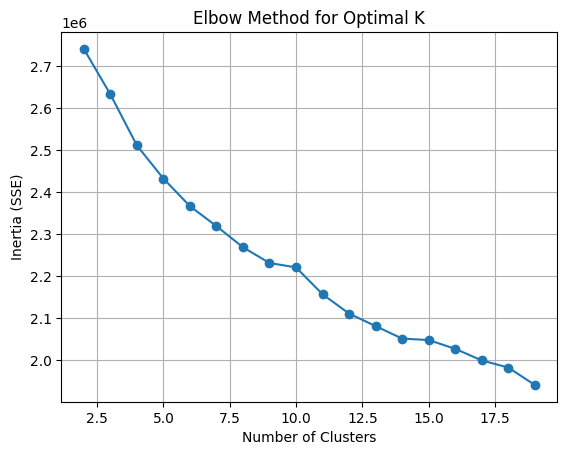

In [31]:
# 试试kmean 聚类

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

joined_cleaned['gentrified'] = joined_cleaned['gentrified'].astype(int)

# Step 1: 取出 SBERT 向量列（你有384维）
sbert_cols = [col for col in joined_cleaned.columns if col.startswith('sbert_')]
X_embed = joined_cleaned[sbert_cols]

inertias = []
cluster_range = range(2, 20)  # 一般选 2~15

for k in cluster_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_embed)
    inertias.append(km.inertia_)

plt.plot(cluster_range, inertias, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

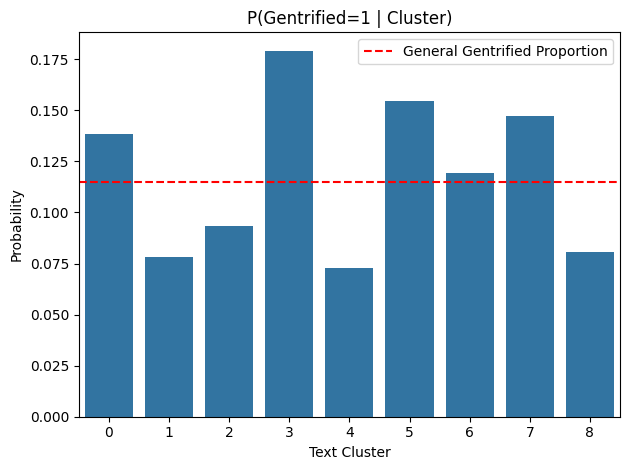

In [32]:
# Step 2: 聚类， 根据之前的结果可以选6或11
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
joined_cleaned['text_cluster'] = kmeans.fit_predict(X_embed)

# Step 3: One-hot 编码这些 cluster（也可以直接用 cluster label）
onehot = pd.get_dummies(joined_cleaned['text_cluster'], prefix='anchor_cluster')

# 查看各个聚类中 gentrified 的比例
cluster_g =  joined_cleaned.groupby('text_cluster')['gentrified'].mean().sort_values()
sns.barplot(x=cluster_g.index, y=cluster_g.values)
plt.title("P(Gentrified=1 | Cluster)")
plt.ylabel("Probability")
plt.xlabel("Text Cluster")
plt.axhline(y= joined_cleaned['gentrified'].mean(), color='red', linestyle='--', label='General Gentrified Proportion')
plt.legend()
plt.tight_layout()
plt.show()

# Bertopic & LDA

Have a look into the clusters

In [ ]:
for c in range(n_clusters):
    print(f"\n Cluster {c}:")
    sample_texts = joined_cleaned[joined_cleaned['text_cluster'] == c]['description'].sample(9, random_state=42)
    for t in sample_texts:
        print(f"- {t}")


 Cluster 0:
- Non material amendment to planning permission 19/00977/HOU (Demolition of existing garage and erection of single storey side and rear extension and a new wall) as amended by 19/02117/NMA to install solar panels on flat roof
- Submission of details pursuant to Condition 3 (Rooflight Details) of Planning Permission dated 13.06.2018 Ref:18/1310/HD for Installation of a new Velux rooflight to front roof slope.
- Non material amendment to planning permission 2014/0610 dated 20/01/2015 to allow retention of existing electrical substation in the front and centre of the proposed building at ground floor level; to increase the size of the core; to decrease residential and commercial floorspace; to increase the massing at 4th floor level; to alter the window arrangement on the side elevation; to increase the building's depth at 1st to 4th floor level; to remove a set in at the side elevation.
- Variation of condition 2 (Approved Plans) of planning permission Ref: 19817/APP/2019/17

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

texts = joined_cleaned[joined_cleaned['text_cluster'] == 3]['description']
vec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=10)
X = vec.fit_transform(texts)
top_words = vec.get_feature_names_out()
print(f"\n Cluster {3} Top Words:")
print(top_words)


 Cluster 3 Top Words:
['display' 'fascia' 'illuminated' 'installation' 'internally'
 'internally illuminated' 'measuring' 'non' 'non illuminated' 'sign']


In [38]:
from sklearn.decomposition import LatentDirichletAllocation

# 针对某一 cluster 的文本
texts_cluster_2 = joined_cleaned[joined_cleaned['text_cluster'].isin([0, 3, 5, 7])]['description']

# 文本转词袋
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_cluster = vectorizer.fit_transform(texts_cluster_2)

# LDA 主题建模
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_cluster)

# 展示关键词
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print([words[i] for i in topic.argsort()[:-11:-1]])

Topic #1:
['rear', 'floor', 'existing', 'new', 'extension', 'replacement', 'windows', 'roof', 'ground', 'alterations']
Topic #2:
['parking', 'associated', 'storey', 'landscaping', 'car', 'planning', 'cycle', 'building', 'demolition', 'access']
Topic #3:
['illuminated', 'installation', 'sign', 'internally', 'display', 'fascia', 'measuring', 'non', 'height', 'signs']
Topic #4:
['use', 'class', 'change', 'floor', 'a1', 'ground', 'c3', 'b1', 'residential', 'office']
Topic #5:
['planning', 'condition', 'permission', 'dated', 'details', 'pursuant', 'ref', 'ful', '18', 'submission']


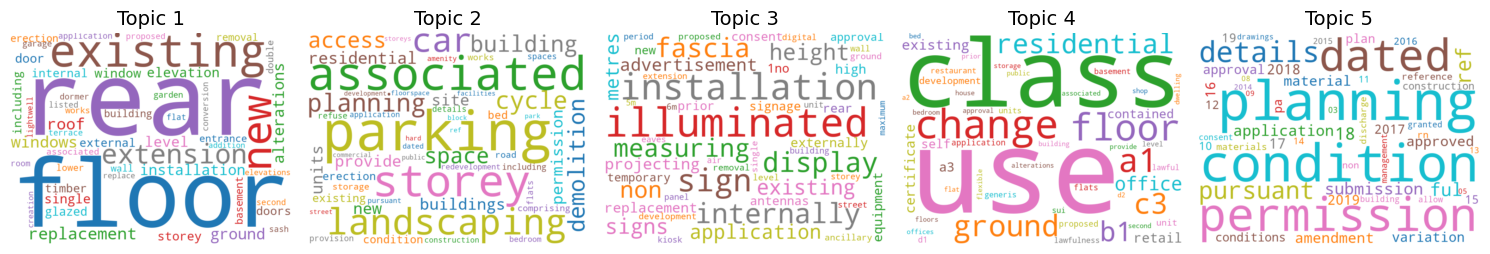

In [39]:
from wordcloud import WordCloud

# 获取词表
words = vectorizer.get_feature_names_out()

# 为每个主题生成词云
fig, axes = plt.subplots(1, lda.n_components, figsize=(15, 6))

for topic_idx, topic in enumerate(lda.components_):
    # 生成 {词: 权重} 字典
    freq_dict = {words[i]: topic[i] for i in topic.argsort()[:-51:-1]}  # 取前50个词
    
    wc = WordCloud(width=800, height=600,
                   background_color='white',
                   colormap='tab10').generate_from_frequencies(freq_dict)
    
    axes[topic_idx].imshow(wc, interpolation='bilinear')
    axes[topic_idx].axis('off')
    axes[topic_idx].set_title(f"Topic {topic_idx+1}", fontsize=14)

plt.tight_layout()
plt.show()

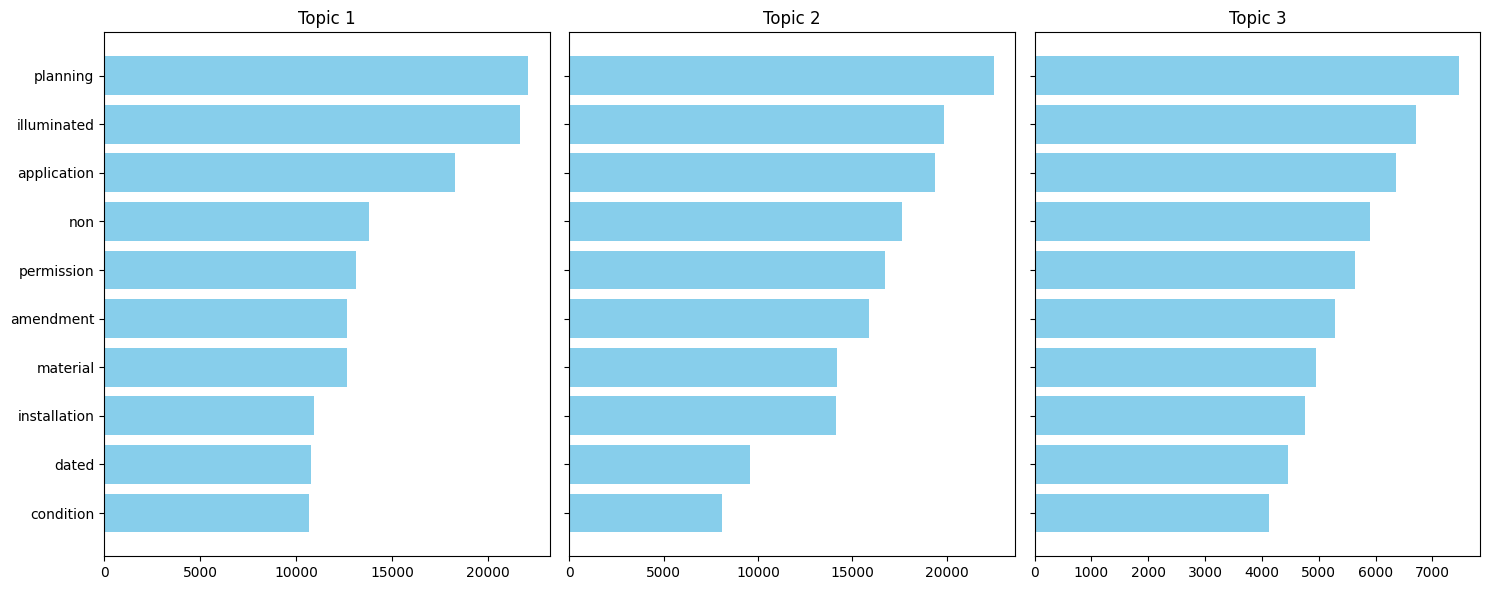

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 获取词表
words = vectorizer.get_feature_names_out()

# 画每个主题的关键词权重条形图
fig, axes = plt.subplots(1, lda.n_components, figsize=(15, 6), sharey=True)

for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[:-11:-1]  # Top 10 关键词索引
    top_words = words[top_indices]         # 对应词
    top_weights = topic[top_indices]       # 权重
    
    ax = axes[topic_idx]
    ax.barh(range(len(top_words)), top_weights, color='skyblue')
    ax.set_yticks(range(len(top_words)))
    ax.set_yticklabels(top_words)
    ax.invert_yaxis()
    ax.set_title(f"Topic {topic_idx+1}")

plt.tight_layout()
plt.show()

In [ ]:
import re

def clean_text(text):
    text = text.lower()  # 降为小写
    text = re.sub(r'[^\w\s]', ' ', text)  # 删除所有标点符号（替换为空格）
    text = re.sub(r'\b(please|see|attached|application|form|number|app|visit|consent|pre|for|no|is)\b', '', text)
    text = re.sub(r'\s+', ' ', text)  # 多个空格变一个
    return text.strip()


joined_cleaned['clean_text'] = joined_cleaned['description'].apply(clean_text)

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

texts = joined_cleaned[joined_cleaned['text_cluster'].isin([0, 3, 5, 7])]['clean_text'].tolist()
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# 手动构造 HDBSCAN 模型，限制线程
hdbscan_model = HDBSCAN(min_cluster_size=10, core_dist_n_jobs=1)

topic_model = BERTopic(
    embedding_model=embedding_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(texts_cluster_2)

topic_model.get_topic_info()
topic_model.get_topic(0)
topic_model.visualize_barchart()

2025-08-10 15:32:34,767 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/166 [00:00<?, ?it/s]

2025-08-10 15:34:27,689 - BERTopic - Embedding - Completed ✓
2025-08-10 15:34:27,689 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-10 15:34:29,240 - BERTopic - Dimensionality - Completed ✓
2025-08-10 15:34:29,240 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-10 15:34:29,362 - BERTopic - Cluster - Completed ✓
2025-08-10 15:34:29,367 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-10 15:34:29,497 - BERTopic - Representation - Completed ✓


# 语义增强

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class EnhancedSemanticFocuser(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_centers, similarity_thresh=0.75, top_k=3):
        """
        cluster_centers: list of ndarray, 每个形状 (emb_dim,)
        """
        # 确保中心向量是 numpy 数组
        self.cluster_centers = [np.asarray(c) for c in cluster_centers]
        self.thresh = similarity_thresh
        self.top_k = top_k

    def fit(self, X, y=None):
        return self  # 不需要额外 fit

    def transform(self, X):
        """
        X: list of regions，每个 region 是形状 (n_sentences, emb_dim) 的嵌入向量列表或 ndarray
        返回: ndarray, 形状 (n_regions, 6)
        """
        region_features = []

        for region_embs in X:
            # --- 关键：先转 ndarray，保证下面乘法、norm 都能用 ---
            region_embs = np.asarray(region_embs)  
            key_sigs = []
            all_sims = []

            for emb in region_embs:
                # emb 现在是 ndarray，cosine_similarity 接受 shape (1, emb_dim)
                sims = cosine_similarity(emb.reshape(1, -1), 
                                         np.vstack(self.cluster_centers))[0]
                all_sims.append(sims)

                max_sim = sims.max()
                if max_sim > self.thresh:
                    # 强度加权
                    weight = 1 + (max_sim - self.thresh)/(1 - self.thresh) * 2
                    key_sigs.append(emb * weight)

            n_sents = region_embs.shape[0]
            n_sig   = len(key_sigs)
            ratio   = n_sig / n_sents if n_sents else 0

            if n_sig == 0:
                region_features.append([n_sig, ratio, 0, 0, 0, 0])
            else:
                norms    = [np.linalg.norm(v) for v in key_sigs]
                avg_sims = np.mean(all_sims, axis=0)
                region_features.append([
                    n_sig,                # 关键句数量
                    ratio,                # 占比
                    np.max(norms),        # 最大信号强度
                    np.mean(norms),       # 平均信号强度
                    avg_sims.max(),       # 与最近簇的相似度
                    avg_sims.mean()       # 所有簇平均相似度
                ])

        return np.array(region_features)



# 测试集

In [ ]:
# 假设你已经在 train_df 上训练好了 kmeans
# 并且你有 test_df 和 SBERT 向量列
X_test_embed = test_df[sbert_cols]

# 预测测试集的聚类标签（使用训练好的模型）
test_df['text_cluster'] = kmeans.predict(X_test_embed)

# One-hot 编码 test 集聚类标签
test_onehot = pd.get_dummies(test_df['text_cluster'], prefix='anchor_cluster')

# 保证训练集和测试集的 one-hot 维度一致（避免缺失类别）
missing_cols = set(onehot.columns) - set(test_onehot.columns)
for col in missing_cols:
    test_onehot[col] = 0
test_onehot = test_onehot[onehot.columns]  # 保证顺序一致

In [ ]:
numeric_features = ['pop_growth_rate', 'price_grow', 'avg_den', 'senior_per', 'minority_per']

In [ ]:
# 构建训练集特征 + 标签
X_train = pd.concat([train_df[numeric_features], onehot], axis=1)
y_train = train_df['gentrified'].astype(int)


# 构建测试集特征
X_test = pd.concat([test_df[numeric_features], test_onehot], axis=1)
y_test = test_df['gentrified'].astype(int)  # 如果你有真实标签

# 训练 XGBoost 模型
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# 预测 & 评估
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41263
           1       1.00      1.00      1.00      5348

    accuracy                           1.00     46611
   macro avg       1.00      1.00      1.00     46611
weighted avg       1.00      1.00      1.00     46611



In [ ]:
text_clu = train_df[train_df['text_cluster'] == 2]['description']

In [ ]:
# 创建 cluster 2 的布尔标记列
test_df['cluster_2_flag'] = (test_df['text_cluster'] == 2).astype(int)
test_df['cluster_5_flag'] = (test_df['text_cluster'] == 5).astype(int)
test_df['cluster_6_flag'] = (test_df['text_cluster'] == 6).astype(int)

# 以 LSOA 分组，统计 cluster 2 的比例
lsoa_cluster2_rate = (
    test_df.groupby('LSOA code')['cluster_2_flag']
    .mean()
    .rename('cluster_2_rate')
    .reset_index()
)

lsoa_cluster5_rate = (
    test_df.groupby('LSOA code')['cluster_5_flag']
    .mean()
    .rename('cluster_5_rate')
    .reset_index()
)

lsoa_cluster6_rate = (
    test_df.groupby('LSOA code')['cluster_6_flag']
    .mean()
    .rename('cluster_6_rate')
    .reset_index()
)

# 合并两个表
lsoa_summary = lsoa_cluster2_rate.merge(lsoa_cluster5_rate, on='LSOA code')
lsoa_summary = lsoa_summary.merge(lsoa_cluster6_rate, on='LSOA code')
print(lsoa_summary.head(5))

   LSOA code  cluster_2_rate  cluster_5_rate  cluster_6_rate
0  E01000001        0.263158        0.684211        0.052632
1  E01000002        0.500000        0.470588        0.000000
2  E01000003        0.692308        0.307692        0.000000
3  E01000005        0.756757        0.243243        0.000000
4  E01000007        0.200000        0.400000        0.000000


In [ ]:
lsoa_summary.to_csv("data/cluster_scores_test.csv", index=False)

In [ ]:
lsoa_summary.shape

(3891, 4)

In [ ]:
# 2.1 按 LSOA code 收集该区域所有句子嵌入
sbert_cols = [c for c in train_df.columns if c.startswith('sbert_')]
grouped = train_df.groupby('LSOA code')[sbert_cols] \
                  .apply(lambda df: df.values.tolist())

ls_list = grouped.index.tolist()       # 所有 LSOA code
embs_list = grouped.values.tolist()    # 每个元素是 ndarray 列表

# 2.2 构造 Focuser，并喂入簇中心
centers = [kmeans.cluster_centers_[i] for i in [2,5,6]]
focuser = EnhancedSemanticFocuser(cluster_centers=centers,
                                  similarity_thresh=0.75,
                                  top_k=3)
focuser.fit(None)  # no-op

# 2.3 计算每个 LSOA 的语义特征
sem_feats = focuser.transform(embs_list)
sem_cols  = ['sem_count', 'sem_ratio', 'sem_max_norm',
             'sem_mean_norm', 'sem_max_sim', 'sem_mean_sim']

df_sem = (pd.DataFrame(sem_feats, columns=sem_cols)
            .assign(**{'LSOA code': ls_list}))

# 2.4 合并到原来的 summary
lsoa_summary = (
    lsoa_summary
    .merge(df_sem, on='LSOA code', how='left')
)

In [ ]:
print(lsoa_label.shape)
print(lsoa_label.columns)

(4835, 25)
Index(['LSOA code', 'LSOA11NM', 'imd_score_', 'price_grow', '2019_final',
       '25_price_g', '25_imd_imp', 'gentrified', 'geometry', 'pop_growth_rate',
       'avg_den', 'senior_per', 'minority_per', 'all_dwelling', 'shared_per',
       'converted_per', 'level_4_pop', 'level_4_per', 'prof_occ_count',
       'prof_occ_per', 'pro_sale_2019', 'sale_avg', 'single_per',
       'less_10km_per', 'application_count'],
      dtype='object')


In [ ]:
test_df_lsoa = lsoa_summary.merge(lsoa_label, on='LSOA code', how='left')

In [ ]:
print(test_df_lsoa.columns)

Index(['LSOA code', 'cluster_2_rate', 'cluster_5_rate', 'cluster_6_rate',
       'sem_count', 'sem_ratio', 'sem_max_norm', 'sem_mean_norm',
       'sem_max_sim', 'sem_mean_sim', 'LSOA11NM', 'imd_score_', 'price_grow',
       '2019_final', '25_price_g', '25_imd_imp', 'gentrified', 'geometry',
       'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per', 'application_count'],
      dtype='object')


In [ ]:
features_all = ['pop_growth_rate','avg_den', 'senior_per', 
                'pro_sale_2019', 'sale_avg', 
                'application_count',
                'cluster_2_rate', 'cluster_5_rate', 'cluster_6_rate']

In [ ]:
from sklearn.model_selection import train_test_split

features_ext = features_all + sem_cols

X_full = test_df_lsoa[features_ext]
y_full = test_df_lsoa['gentrified'].astype(int)

X_val, X_final_test, y_val, y_final_test = train_test_split(
    X_full, y_full, test_size=0.5, random_state=42
)

# 模型训练
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_val, y_val)

# 预测与评估
from sklearn.metrics import classification_report
y_pred = model.predict(X_final_test)
print(classification_report(y_final_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1772
           1       0.16      0.02      0.03       174

    accuracy                           0.90      1946
   macro avg       0.53      0.50      0.49      1946
weighted avg       0.84      0.90      0.87      1946




===== Cross-Validation Summary =====
Average Accuracy:   0.7623
Average AUROC:      0.5930
Average Log-loss:   0.4246
Average G-mean:     0.5001
Average F1-score:   0.1935
Average Recall:     0.3180
Average AUC-PR:     0.1413

===== Total Confusion Matrix across all folds =====
[[2853  683]
 [ 242  113]]


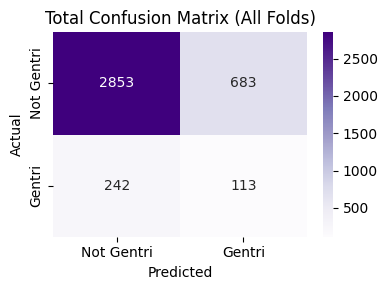

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score, recall_score, f1_score, average_precision_score, confusion_matrix
X = test_df_lsoa[features_ext]
y = test_df_lsoa['gentrified'].astype(int)

# 初始化评估器
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
acc_scores, auc_scores, logloss_scores, gmean_scores, f1s, recalls, auc_prs = [], [], [], [], [], [], []

# 混淆矩阵总计
total_cm = np.array([[0, 0], [0, 0]])

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 自动设置 scale_pos_weight
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    model = XGBClassifier(
        random_state=42,
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        max_delta_step=1,
        learning_rate=0.05,
        n_estimators=200
    )

    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    threshold = 0.4
    y_pred = (y_proba >= threshold).astype(int)

    # 评估
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    ll = log_loss(y_test, y_proba)
    gmean = geometric_mean_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    auc_pr = average_precision_score(y_test, y_proba)

    # 记录评估分数
    acc_scores.append(acc)
    auc_scores.append(auc)
    logloss_scores.append(ll)
    gmean_scores.append(gmean)
    f1s.append(f1)
    recalls.append(recall)
    auc_prs.append(auc_pr)

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    total_cm += cm

# 汇总平均结果
print("\n===== Cross-Validation Summary =====")
print(f"Average Accuracy:   {np.mean(acc_scores):.4f}")
print(f"Average AUROC:      {np.mean(auc_scores):.4f}")
print(f"Average Log-loss:   {np.mean(logloss_scores):.4f}")
print(f"Average G-mean:     {np.mean(gmean_scores):.4f}")
print(f"Average F1-score:   {np.mean(f1s):.4f}")
print(f"Average Recall:     {np.mean(recalls):.4f}")
print(f"Average AUC-PR:     {np.mean(auc_prs):.4f}")

# 打印总混淆矩阵
print("\n===== Total Confusion Matrix across all folds =====")
print(total_cm)

# 可选：总混淆矩阵可视化
plt.figure(figsize=(4, 3))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Gentri', 'Gentri'],
            yticklabels=['Not Gentri', 'Gentri'])
plt.title('Total Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()